In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer
import torch

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("/nlp/scr/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = load_from_disk("./data/occupation_train")
test_dataset = load_from_disk("./data/occupation_test")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/nlp/scr/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=False,
    chop_editor_at_layer=2
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/scr-ssd/sjd24/occupation_debug/final_model")

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

In [7]:
test_dataset = [d for d in test_dataset if d["attribute_type"] == "causal"]
train_dataset = [d for d in train_dataset if d["attribute_type"] == "causal"]

In [8]:
hypernetwork.interpretor.das_module.save_rv = True

In [9]:
collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True)
dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

hypernetwork.interpretor.eval()
test_loss = []
correct_idxs = []
is_causal = []
attributes = []

curr_idx = 0

with torch.no_grad():
    for batch_id, batch in enumerate(dataloader):
        
        example_idxs = range(curr_idx, curr_idx + len(batch["editor_input_ids"]))
        curr_idx += len(batch["editor_input_ids"])
        
        if curr_idx >= len(train_dataset):
            break
        
        corresponding_attribute = [test_dataset[i]["attribute"] for i in example_idxs]
        attributes.extend(corresponding_attribute)
        
        intervention_weight=None
                                        
        predictions = hypernetwork.forward(
            editor_input_ids=batch["editor_input_ids"].to("cuda"),
            base_input_ids=batch["base_input_ids"].to("cuda"),
            base_attention_mask=batch["base_attention_mask"].to("cuda"),
            base_intervention_mask=batch["base_intervention_mask"].to("cuda"),
            source_input_ids=batch["source_input_ids"].to("cuda"),
            source_attention_mask=batch["source_attention_mask"].to("cuda"),
            source_intervention_mask=batch["source_intervention_mask"].to("cuda"),
            labels=batch["labels"].to("cuda"),
            inference_mode=None,
            intervention_weight=intervention_weight
        )
        test_loss.append(predictions["loss"].item())
        
        batch_pred_ids = torch.argmax(predictions["logits"], dim=-1)
        is_causal.extend(batch["is_causal"].cpu().numpy().tolist())
        
        for i, (label, pred_ids) in enumerate(zip(batch["labels"].to("cuda"), batch_pred_ids)):
            label_idx = label != -100
            output_idx = torch.zeros_like(label_idx)
            output_idx[:-1] = label_idx[1:]
            
            label = label[label_idx]
            pred_ids = pred_ids[output_idx]
                        
            is_correct = (torch.sum (label == pred_ids) == torch.numel(label)).item()    
            if is_correct:
                correct_idxs.append(batch_id * len(batch["labels"]) + i)
                

total_causal = sum(is_causal)
total_isolate = len(is_causal) - total_causal

correct_causal = sum([is_causal[i] for i in correct_idxs])
correct_isolate = len(correct_idxs) - correct_causal

causal_acc = correct_causal / total_causal if total_causal > 0 else 0.0
isolate_acc = correct_isolate / total_isolate if total_isolate > 0 else 0.0
disentangle_acc = 0.5 * (causal_acc + isolate_acc)

accuracies = {
    "causal": causal_acc,
    "isolate": isolate_acc,
    "disentangle": disentangle_acc
}

rvs = hypernetwork.interpretor.das_module.rvs
rvs = torch.concatenate(rvs, dim=0)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
rvs = rvs[correct_idxs]
is_causal = [is_causal[i] for i in correct_idxs]
attributes = [attributes[i] for i in correct_idxs]
len(attributes), rvs.shape

(4505, torch.Size([4505, 4096]))

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# TypeError: Got unsupported ScalarType BFloat16
rvs = rvs.float().cpu()

rvs_pca = pca.fit_transform(rvs)

In [11]:
rvs_pca.shape, len(attributes)

((1582, 3), 1582)

In [12]:
labels = []
for i in range(rvs_pca.shape[0]):
    label = attributes[i]
    labels += [label]

In [13]:
len(labels), rvs_pca.shape

(1582, (1582, 3))

ValueError: not enough values to unpack (expected 3, got 0)

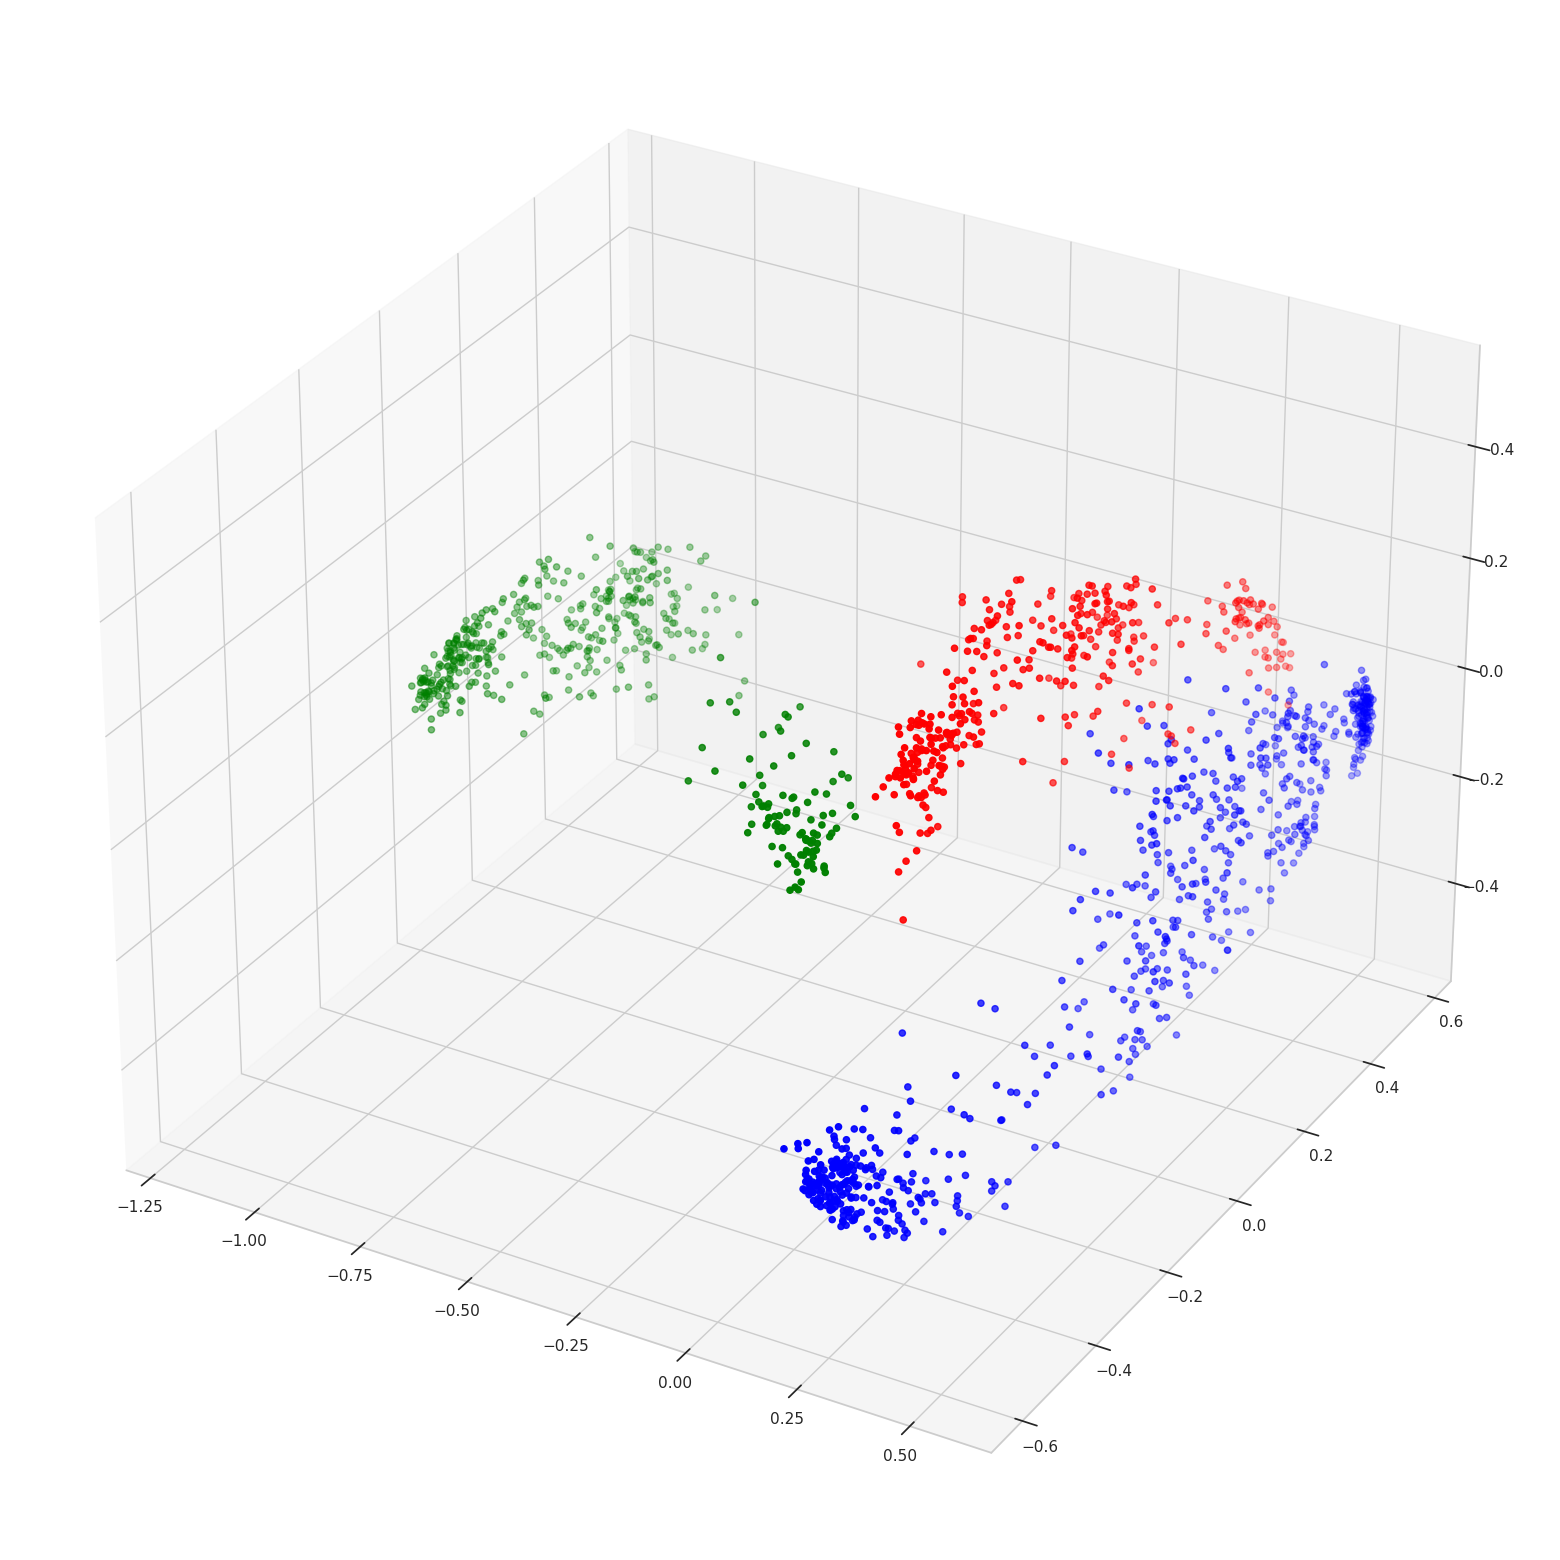

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set(style='whitegrid')

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

colors = {
    'Duty': 'red',
    'Industry': 'green',
    'Work Location': 'blue',
}

# Initialize an empty dictionary to store coordinates by label
grouped = {label: [] for label in colors.keys()}

# Group coordinates by labels
for i in range(rvs_pca.shape[0]):
    x, y, z = rvs_pca[i]
    label = labels[i]
    grouped[label].append((x, y, z))

# Plot each group with its associated color and add to legend
for label, coordinates in grouped.items():
    xs, ys, zs = zip(*coordinates)  # Unzip the list of tuples
    ax.scatter(xs, ys, zs, color=colors[label], label=label)
ax.legend(title="Attributes", fontsize=28, title_fontsize=28, loc='center right', bbox_to_anchor=(1 - 0.1, 1 - 0.225)) # Put the legend inside the plot on the upper right corner
# Set x, y, z tick labels to be larger
ax.tick_params(axis='both', which='major', labelsize=24)

plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05)
plt.show()

fig.savefig("hyperdas_householder_vector.pdf")

In [18]:
classes = ['Duty', 'Industry', 'Work Location']

vector_dict = {}

for label in classes:
    label_idxs = [i for i in range(len(labels)) if labels[i] == label]
    vector_dict[label] = rvs[label_idxs]
    

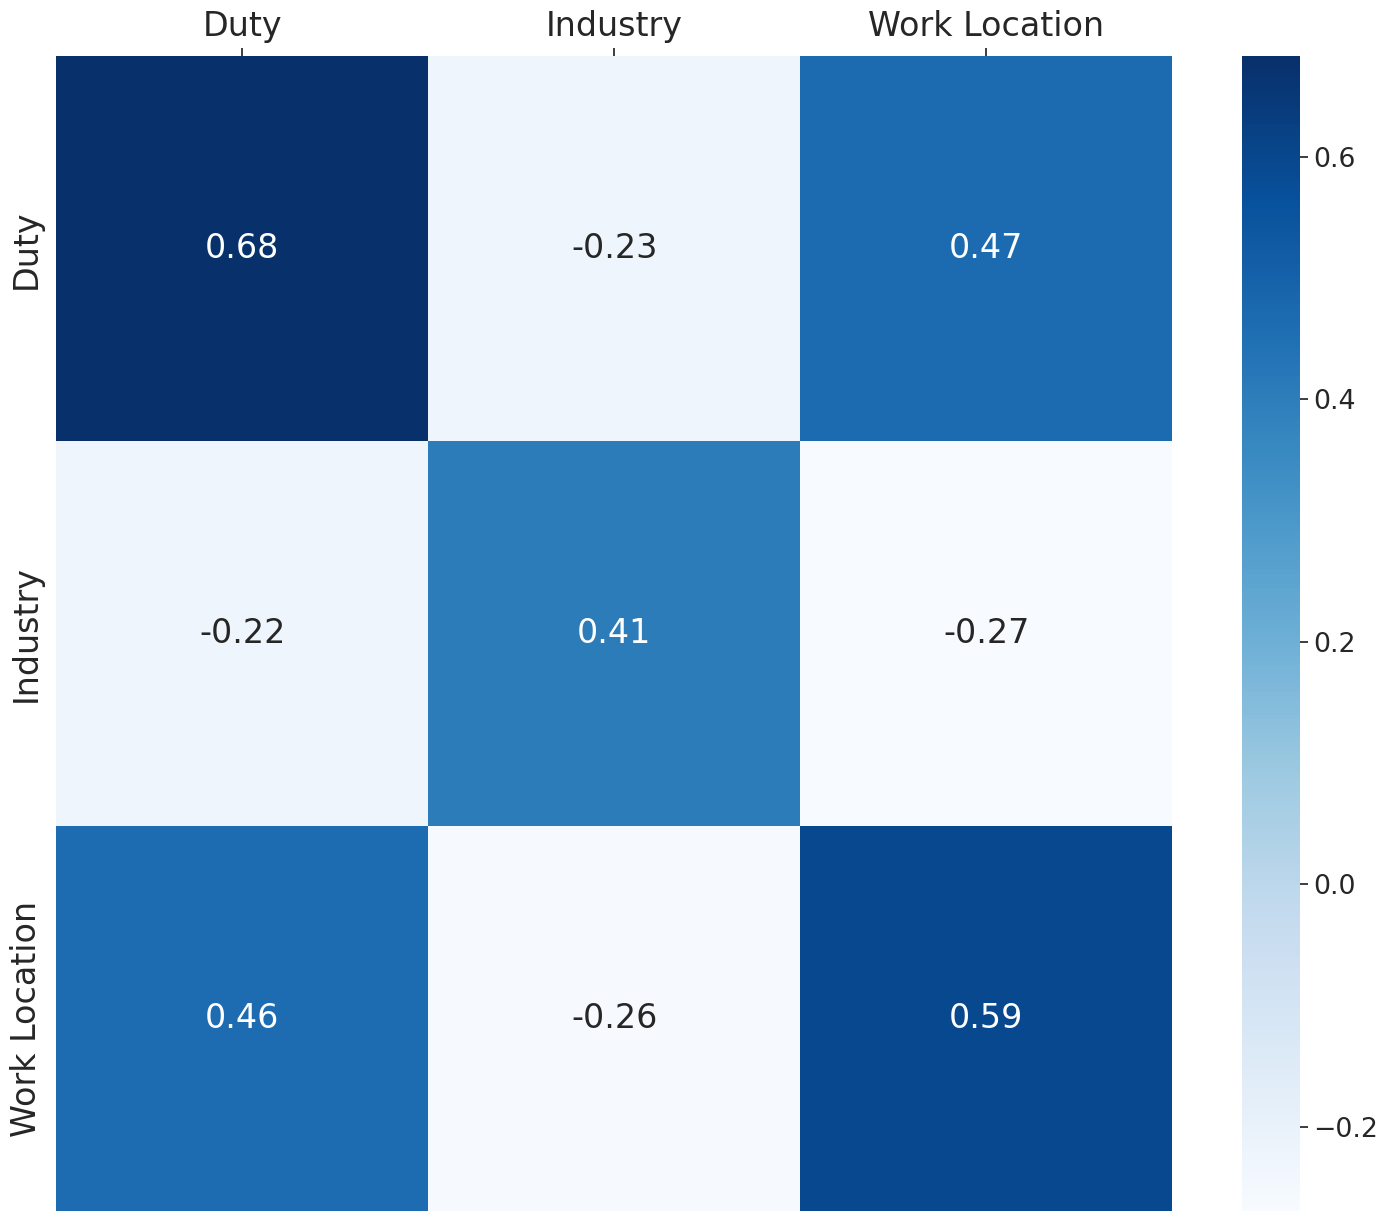

In [20]:
# There are 6 classes in the vector_dict; each class in the dictionary is a numpy array of shape (n_examples, n_features)
# plot a heatmap of the cosine similarity between vectors in each class (sample 1000 pairs of vectors from each classes pair)

import random
from torch.nn.functional import cosine_similarity

n_samples = 10000
classes = ['Duty', 'Industry', 'Work Location']

n_classes = len(['Duty', 'Industry', 'Work Location'])
cosine_similarities = torch.zeros((n_classes, n_classes))

for i, (label1, vectors1) in enumerate(vector_dict.items()):
    for j, (label2, vectors2) in enumerate(vector_dict.items()): 
        

        idx1 = [random.randint(0, vectors1.shape[0] - 1) for _ in range(n_samples)]
        idx2 = [random.randint(0, vectors2.shape[0] - 1) for _ in range(n_samples)]
        
        mat1 = vectors1[idx1]
        mat2 = vectors2[idx2]
        
        sim = cosine_similarity(mat1, mat2, dim=-1)
        sim = torch.mean(sim)
        cosine_similarities[i, j] = sim

        

import seaborn as sns

sns.set(style='whitegrid', font_scale=1.75)
fig, ax = plt.subplots(figsize=(18, 15))

# use dark blue to light blue for high to low similarity
sns.heatmap(cosine_similarities, annot=True, cmap="Blues", xticklabels=vector_dict.keys(), yticklabels=vector_dict.keys(), ax=ax, fmt=".2f")
# plt.title("Cosine Similarity between Reflection Vectors")

# Set x, y tick labels to be larger
ax.tick_params(axis='both', which='major', labelsize=24)

# Set heatmap annotation to be larger
for text in ax.texts:
    text.set_fontsize(24)

# Move the x-axis to the top
plt.gca().xaxis.tick_top()

fig.savefig("hyperdas_cosine_similarity.pdf")

plt.show()
        
